## Mobile Games A/B Testing: Cookie Cats
---
[Cookie Cats](https://www.facebook.com/cookiecatsgame) is a mobile puzzle game developed by [Tactile Entertainment](https://tactilegames.com/). It's  a traditional puzzle game in the style of "connect three", where the player is tasked with linking tiles of identical color in order to clear the board and successfully complete the level.


<div style="text-align: center">
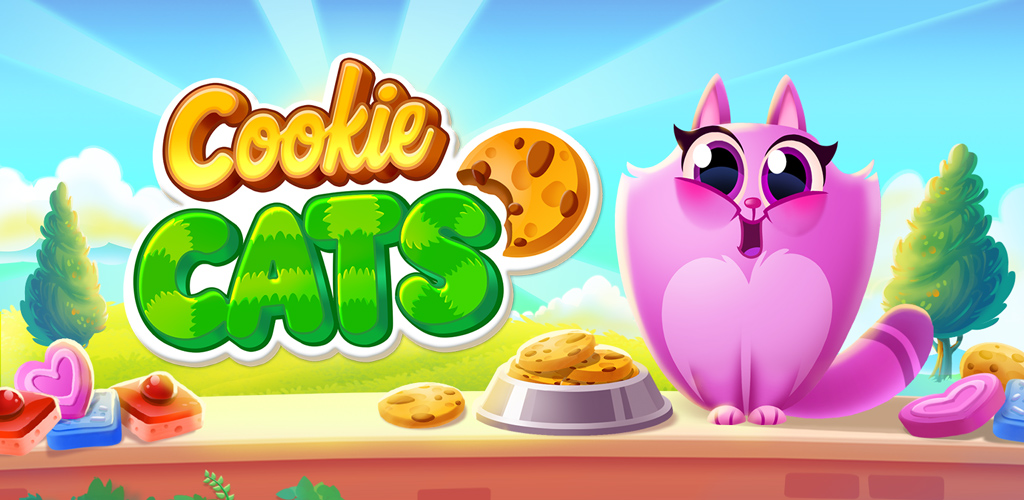
</div>

- As players advance in the game, they periodically encounter gates. These gates require either a significant waiting period or an in-app purchase for the player to continue.


- These gates not only stimulate in-app purchases, but also enforce a break for players. This strategy aims to enhance and prolong the player's enjoyment of the game.


- A critical question arises: **where should these gates be positioned?** Initially, the first gate was established at level 30.


- The goal of this project will analyze an AB-test where the first gate in Cookie Cats was shifted from level 30 to level 40. The scope will be focus on observing the impact on player retention.


- Prior to diving into the analysis, it's essential to understand the data comprehensively.



## Dataset Introduction

The data shown from 90,189 players that installed the game while the AB-test was running. 

The variables are:

- **userid** - A unique number that identifies each player.


- **version** - Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).


- **sum_gamerounds** - The number of game rounds played by the player during the first 14 days after install.


- **retention_1** - Did the player come back and play 1 day after installing?


- **retention_7** - Did the player come back and play 7 days after installing?


When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Read the dataset

df = pd.read_csv('cookie_cats.csv')

df.head()


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## Descriptive statistics

In this phrase, we will dive into the differences between A/B group based on the variables.

In [4]:
# Number of unique player
df['userid'].nunique()

90189

In [5]:
# Counting the number of players in each group (A/B)
df.groupby('version')[['userid']].nunique()

,userid
version,
gate_30,44700
gate_40,45489


It appears that each group has approximately the same number of players, which is nice!


While the primary objective of this analysis is to examine the influence of gate placement on player retention, as an interesting aside, we will also graph the distribution of the number of game rounds played by players in their first week of gameplay.

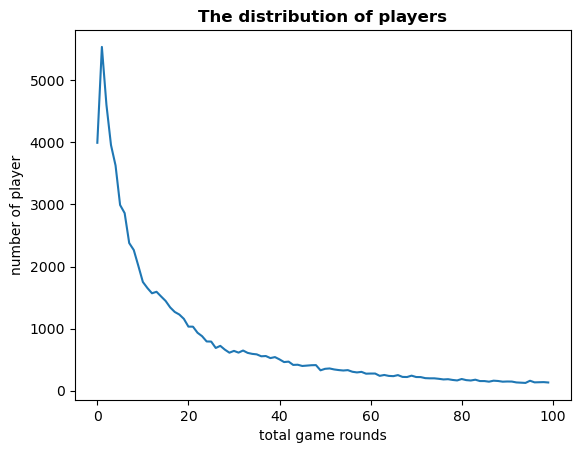

In [10]:
# The distribution of game rounds
# Get the number of players for different game rounds
game_rounds = df.groupby('sum_gamerounds')['userid'].count()

#game_rounds

# Plot the distribution with players who have played 0 to 100 game rounds
ax = game_rounds.head(100).plot()

plt.title('The distribution of players', fontweight = 'bold')
plt.xlabel('total game rounds')
plt.ylabel('number of player')

plt.show()


According to the graph, we can see that some players they don't play (level 0) after installing the game.

In [11]:
# Find the number of players who installed game but never play it
df[df['sum_gamerounds'] == 0]['userid'].count()

3994

There are around 4000 players never played the game.

Based on the results, we will analyze another metric called retention. The higher the retention, the easier the game is to retain players and build a large player base.

In our dataset, we have 1-day and 7-days retention.

In [13]:
# 1 day and 7 days retention rate
df_retention = df[["retention_1","retention_7"]].mean()*100

print(f"1-day retention rate: {round(df_retention[0],2)}% \
      \n7-days retention rate: {round(df_retention[1],2)}%")

1-day retention rate: 44.52%       
7-days retention rate: 18.61%


44.52% of players come back one day after installing the game, and 18% of players come back 7 days after installing the game.

In [14]:
# Calculating two retention rate for each A/B test group
df_ab = df.groupby('version').agg({'userid':'count', 'retention_1':'mean','retention_7':'mean',
                                  'sum_gamerounds':'sum'})

df_ab

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44700,0.448188,0.190201,2344795
gate_40,45489,0.442283,0.182000,2333530


In one day retentaion, there was a slightly decrease in gate 40, 44.2%, compared to the control group (44.8%).

Also, in seven day retention, the retenation rate dropped whe gate moved to level 40.

### A/B testing: Bootstrapping

We will use boostrapping for A/B testing. 

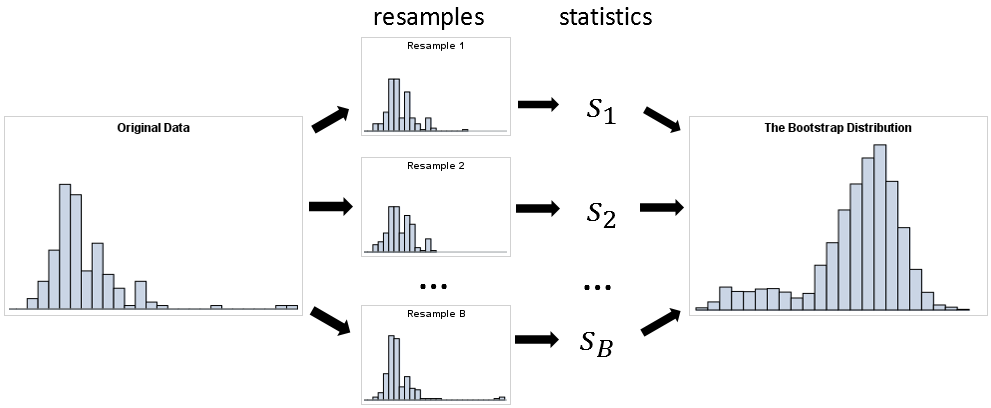

#### Steps:

1. Creating 500 samples of dataset (***bootstraping***)


2. Calculating 1-day & 7-days retentions for A/B groups


3. Plotting the bootstrap distributions


4. Calculating retention rate difference between the two A/B groups


5. Calculating the probability that 1-day & 7-days retentions are greater when the gate is at level 30


6. Evaluating results and making recommendation
---

***Picture reference:
https://blogs.sas.com/content/iml/2018/12/12/essential-guide-bootstrapping-sas.html***

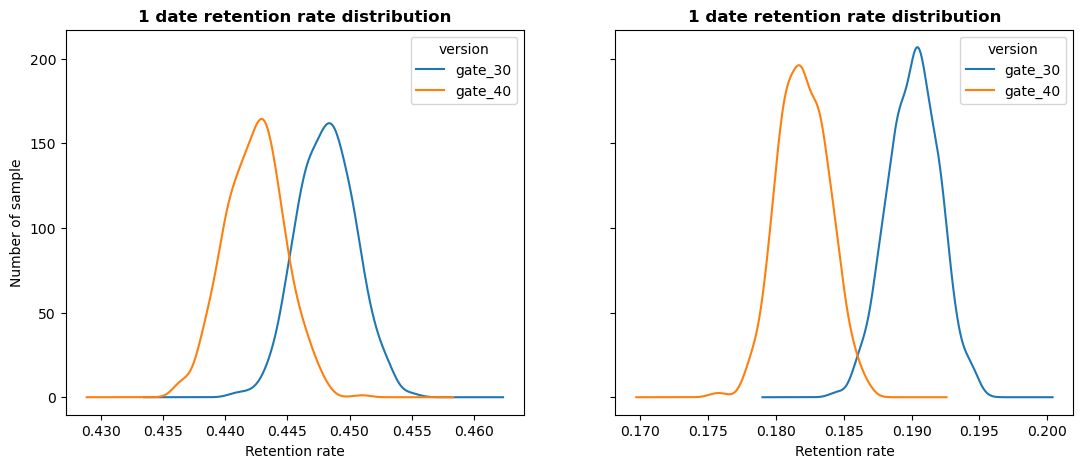

In [18]:
# First, we will create a list with bootstrapeped means for each group
boot1 = []
boot7 = []

for i in range(500):
    boot1_mean = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot7_mean = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    
    boot1.append(boot1_mean)
    boot7.append(boot7_mean)

# Transforming the list to a df
boot1 = pd.DataFrame(boot1)
boot7 = pd.DataFrame(boot7)

# Kernel Density Estimate plot of the bootstrap distributions
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(13,5))

boot1.plot.kde(ax=ax1)
ax1.set_xlabel('Retention rate')
ax1.set_ylabel('Number of sample')
ax1.set_title('1 date retention rate distribution', fontweight = 'bold')

boot7.plot.kde(ax=ax2)
ax2.set_xlabel('Retention rate')
ax2.set_title('1 date retention rate distribution', fontweight = 'bold')

plt.show()


There has a slightly difference between these distributions.

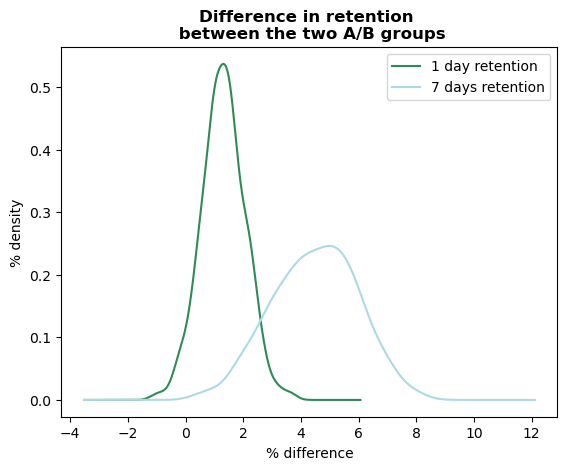

In [19]:
# Add a column to show the difference between group A and B
boot1['diff'] = ((boot1['gate_30'] - boot1['gate_40']) / boot1['gate_40'] * 100)
boot7['diff'] = ((boot7['gate_30'] - boot7['gate_40']) / boot7['gate_40'] * 100)

# Ploting the bootstrap difference by ratio
fig, (ax1) = plt.subplots(1, 1)

boot1['diff'].plot.kde(ax=ax1, c="seagreen", label = "1 day retention")
boot7['diff'].plot.kde(ax=ax1, c= "lightblue", label = "7 days retention")

ax1.set_xlabel("% difference")
ax1.set_ylabel("% density")
ax1.set_title("Difference in retention \n between the two A/B groups", fontweight="bold")
plt.legend()

plt.show()


After focus on the difference between 1 day and 7 days retention, we found that most of the distribution is above 0 %. For 1 day retention, the difference would be around 1% to 2%. For 7 day retention, the difference would be 2% to 5%.

In [22]:
# Calculating the probability that 1 and 7 day retention is greater when the gate
# is at level 30
prob_1 = (boot1['diff']>0).sum()/len(boot1['diff'])

prob_7 = (boot7['diff']>0).sum()/len(boot7['diff'])

print(f"The probability that 1-day retention is greater when the gate is at level 30: {round(prob_1,2)*100}% \
      \n\nThe probability that 7-days retention is greater when the gate is at level 30: {(prob_7)*100}% ")

The probability that 1-day retention is greater when the gate is at level 30: 96.0%       

The probability that 7-days retention is greater when the gate is at level 30: 100.0% 


### Conclusion

The results from our bootstrap analysis are pretty compelling. They suggest with a whopping 99.8% probability that having the gate at level 30 leads to higher 7-day retention compared to having it at level 40.

For the takeaway, if our goal is to keep both 1-day and 7-day retention rates high, we really shouldn't move the gate from level 30 to level 40. Since retention is a key metric, we could take the results into consider.